<a href="https://colab.research.google.com/github/luisfflorezg/UTB_ST/blob/master/DodgerLoopDay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DodgerLoopDay (Ejercicio Clase)

##PARTE1
Buscamos siete series de tiempo, una para cada día
(para cada serie de tiempo) hagamos el proceso completo de análisis de la serie temporal, que significa:


*   Hacer un gráfico para cada serie

*   Establecer la descomposición de la serie (Tendencia, estacionalidad, ruido..)

*   Hacer la prueba de Dickey-Fuller para establecer si es verdad es estacional o no.


*   Calcular la auto-correlación y analizar la gráfica de autocorrelación.


*   Luego finalmente para cada serie (para cada día) hacer una predicción usando Exponential smooth forecast (parte III del otro notebook)


*   Hacer una tabla resumen con las métricas de la predicción


*   Hacer conclusiones, analizar todo!


##Carga de datos

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
!pip3 install aeon
import os
import aeon
from aeon.datasets import load_from_tsfile

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

In [121]:
train_x, train_y = load_from_tsfile("/content/drive/MyDrive/UTB_ST/ejercicio_clase_20231104/DodgerLoopDay/DodgerLoopDay_TRAIN.ts")
# Aplicar la transformación a los valores cero o negativos
train_x = np.maximum(train_x, 0.1)


In [122]:
len(train_y)

78

In [123]:
print(train_x.shape)


(78, 1, 288)


objeto con 78 series, una dimension por serie, 288 registros de esa dimension.
aparte hay 7 categorias diferentes en las 78 series.

In [124]:
# Crear DataFrame con las columnas "Serie" y "Categoría"
df_series_categoria = pd.DataFrame({'Serie': range(1, 79), 'Categoría': train_y})

# Mostrar el DataFrame resultante
print(df_series_categoria)

    Serie Categoría
0       1         1
1       2         1
2       3         1
3       4         1
4       5         1
..    ...       ...
73     74         7
74     75         7
75     76         7
76     77         7
77     78         7

[78 rows x 2 columns]


In [125]:
#'train_x' es el conjunto de datos de series temporales con forma (78, 1, 288)
# y 'train_y' es la lista de categorías

# Flatten para obtener una forma (78, 288)
train_x_flatten = train_x.reshape((78, 288))

# Inicializar listas para las columnas del DataFrame
serie_column = []
categoria_column = []
valor_column = []

# Iterar sobre las series y categorías
for serie, categoria, valores in zip(range(1, 79), train_y, train_x_flatten):
    # Repetir la serie y categoría para cada valor en la serie
    serie_column.extend([serie] * 288)
    categoria_column.extend([categoria] * 288)
    valor_column.extend(valores)

# Crear el DataFrame
df = pd.DataFrame({'Serie': serie_column, 'Categoría': categoria_column, 'Valor': valor_column})

df['Valor'] = df['Valor'].apply(lambda x: max(0.1, x))

# Mostrar el DataFrame resultante
print(df)


       Serie Categoría  Valor
0          1         1   12.0
1          1         1   18.0
2          1         1   11.0
3          1         1   11.0
4          1         1   19.0
...      ...       ...    ...
22459     78         7   22.0
22460     78         7   21.0
22461     78         7   16.0
22462     78         7   21.0
22463     78         7    6.0

[22464 rows x 3 columns]


df corresponde a un dataframe con cada una de las 7 categorias con sus 288 registros.

Series por dia

Grafico

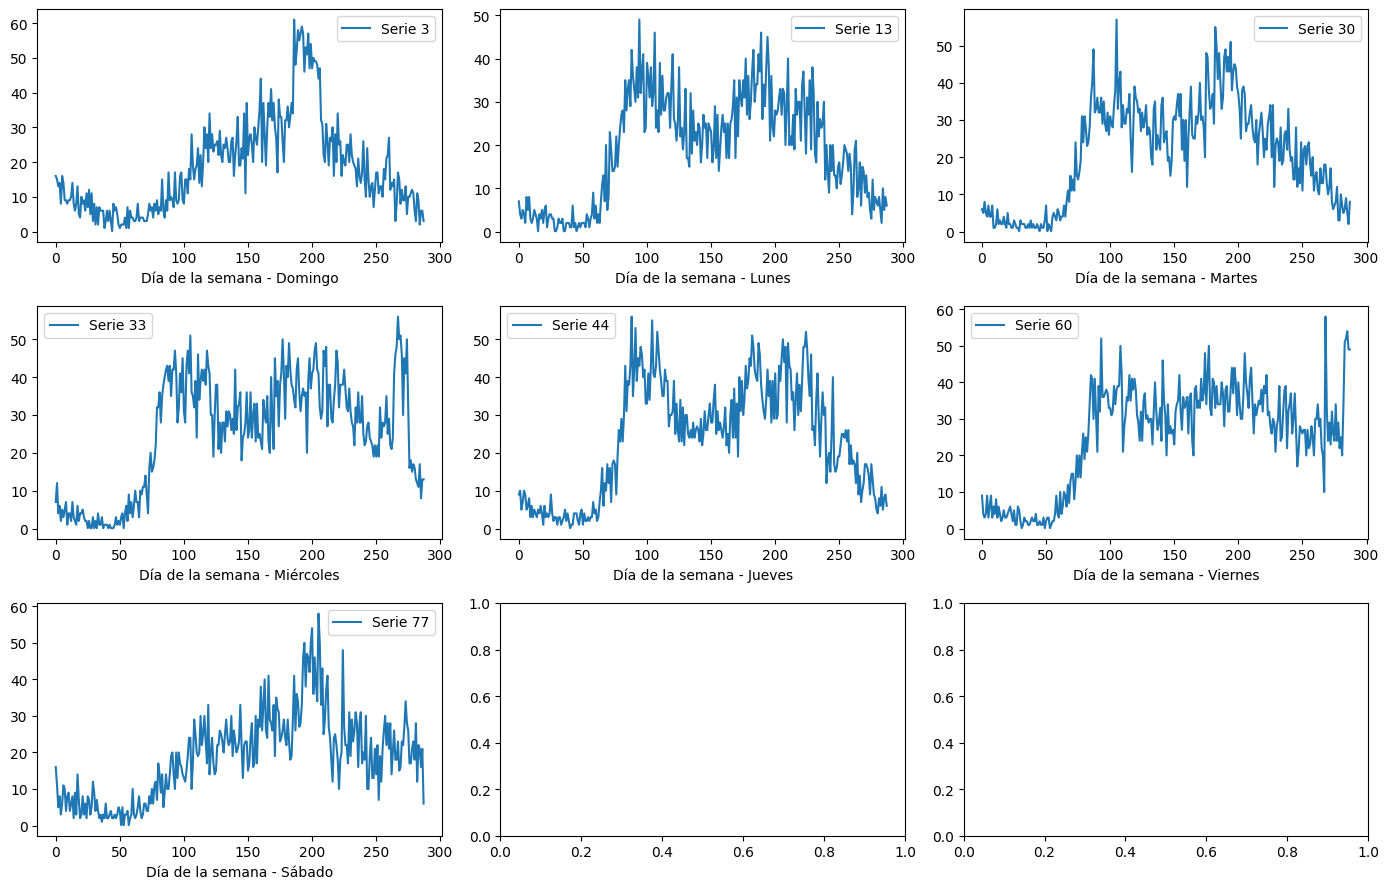

In [126]:
import matplotlib.pyplot as plt

# Definir las series que a visualizar
series_a_visualizar = [3, 13, 30, 33, 44, 60, 77]

# Días de la semana correspondientes a cada serie
dias_semana = ["Domingo", "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"]

# Configurar el tamaño de la figura y la disposición de los subgráficos
num_filas = len(series_a_visualizar) // 3 + (len(series_a_visualizar) % 3 > 0)
fig, axs = plt.subplots(num_filas, 3, figsize=(14, 3 * num_filas))

# Iterar sobre las series y agregar cada una a su propio subgráfico
for i, serie in enumerate(series_a_visualizar):
    fila = i // 3
    columna = i % 3
    axs[fila, columna].plot(train_x[serie][0], label=f"Serie {serie}")
    axs[fila, columna].legend()
    axs[fila, columna].set_xlabel(f"Día de la semana - {dias_semana[i]}")

# Ajustar el diseño de los subgráficos
plt.tight_layout()
plt.show()


Descomposicion

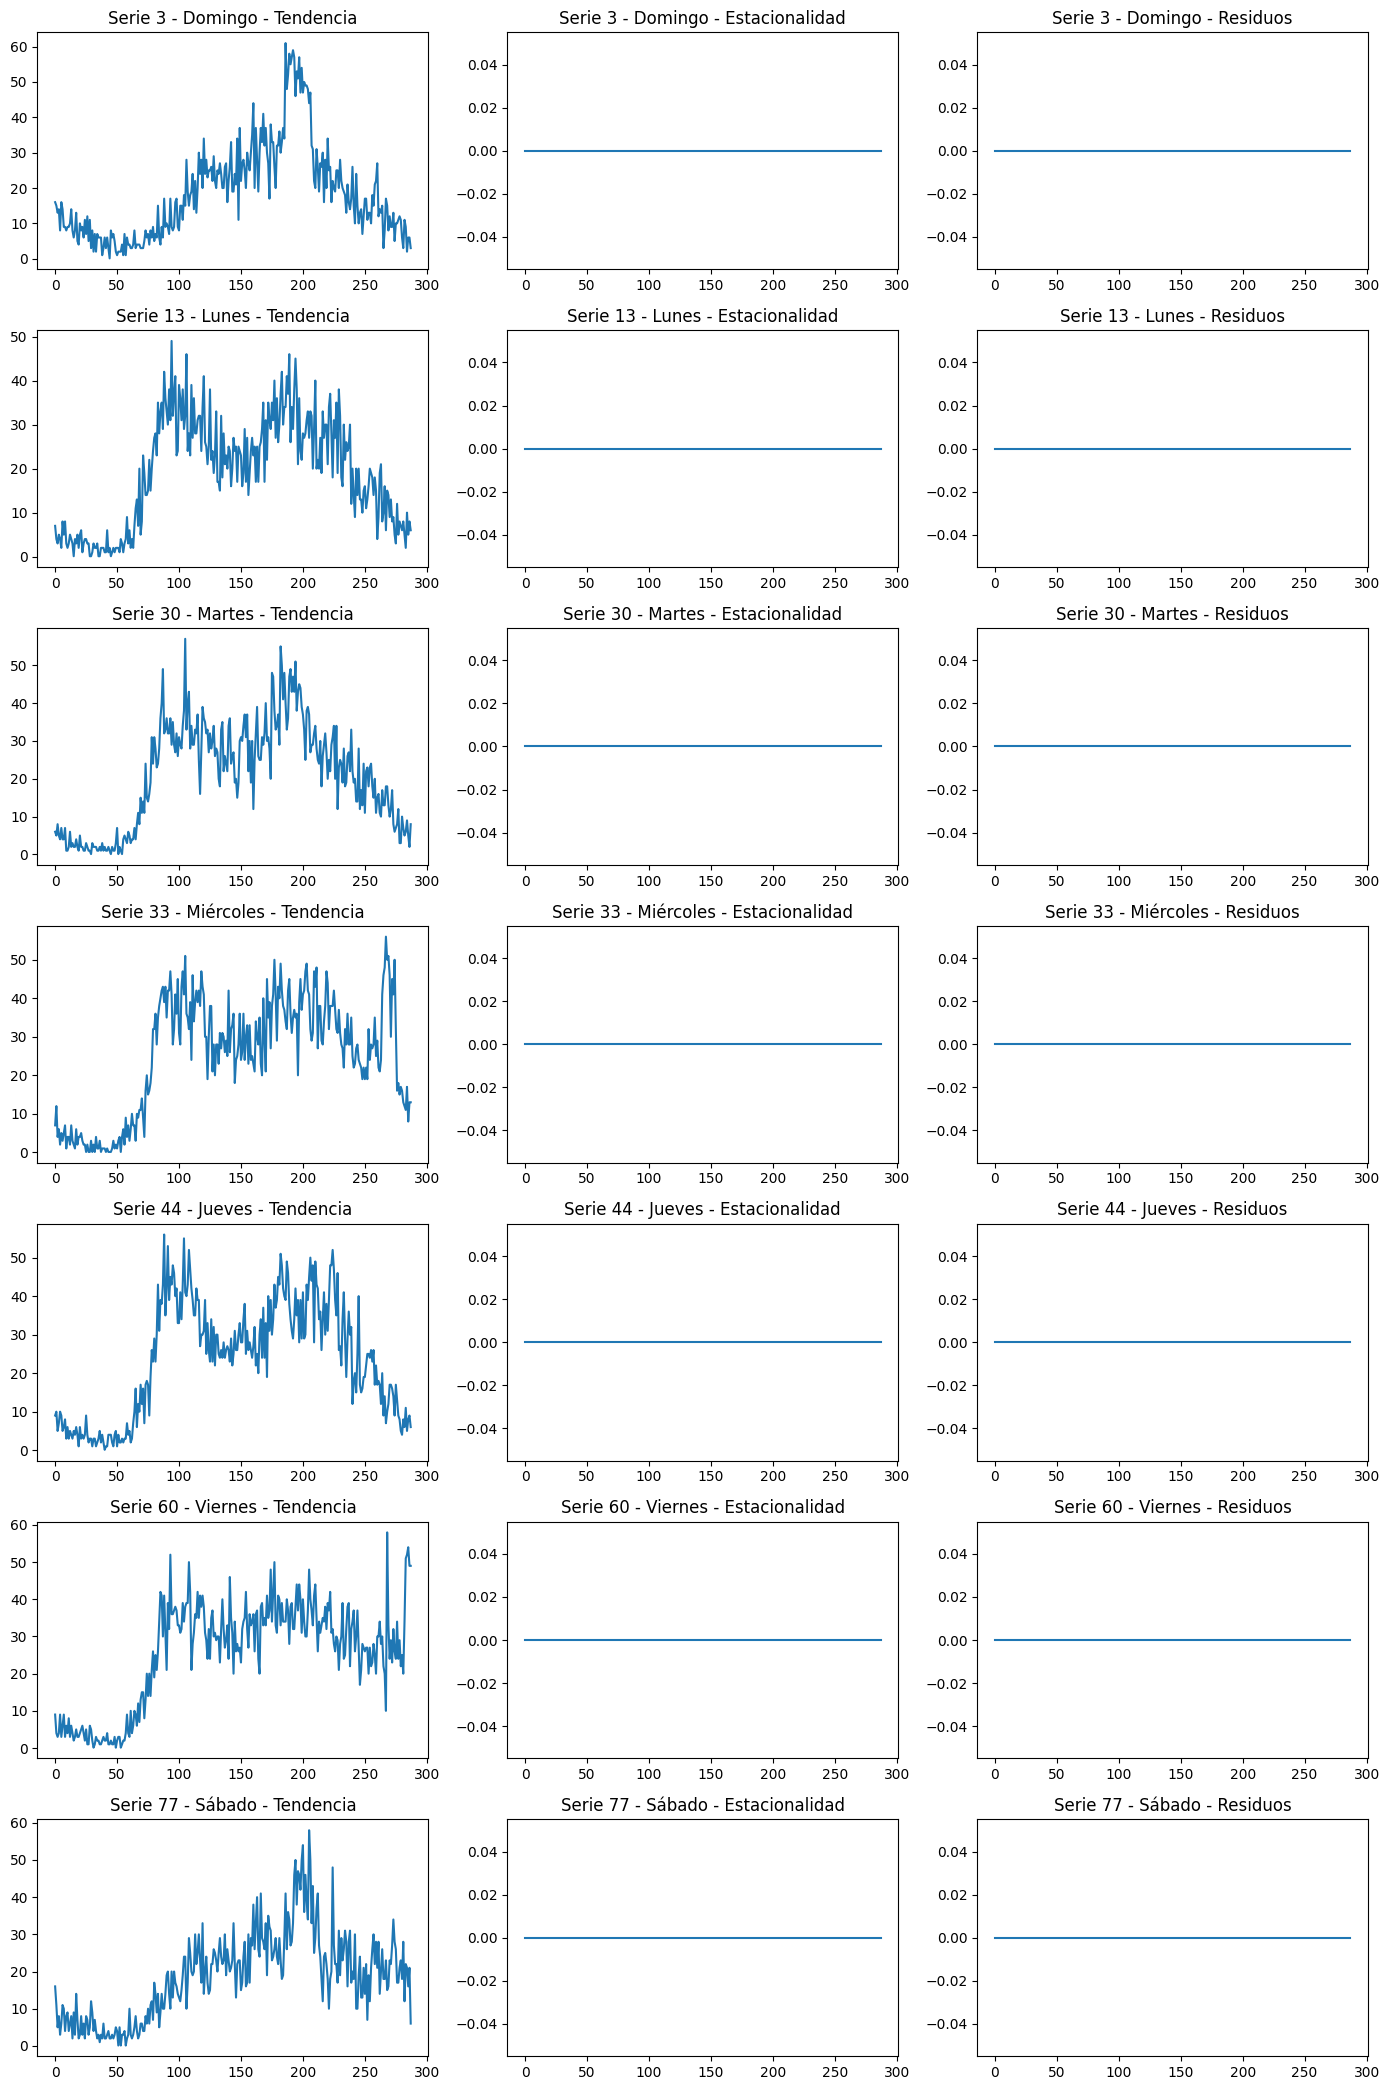

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Definir las series a descomponer
series_a_descomponer = [train_x[serie][0] for serie in series_a_visualizar]

# Días de la semana correspondientes a cada serie
dias_semana = ["Domingo", "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"]

# Configurar el tamaño de la figura y la disposición de los subgráficos
num_filas = len(series_a_descomponer)
fig, axs = plt.subplots(num_filas, 3, figsize=(14, 3 * num_filas))

# Iterar sobre las series y realizar la descomposición para cada una
for i, serie in enumerate(series_a_descomponer):
    dia_semana = dias_semana[i]

    axs[i, 0].set_title(f"Serie {series_a_visualizar[i]} - {dia_semana} - Tendencia")
    axs[i, 0].plot(seasonal_decompose(serie, model='additive', period=1).trend)

    axs[i, 1].set_title(f"Serie {series_a_visualizar[i]} - {dia_semana} - Estacionalidad")
    axs[i, 1].plot(seasonal_decompose(serie, model='additive', period=1).seasonal)

    axs[i, 2].set_title(f"Serie {series_a_visualizar[i]} - {dia_semana} - Residuos")
    axs[i, 2].plot(seasonal_decompose(serie, model='additive', period=1).resid)

# Ajustar el diseño de los subgráficos
plt.tight_layout()
plt.show()


Estacionaridad (dickey_fuller_test)

In [128]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def dickey_fuller_test(time_series, series_name):
    # Perform the Dickey-Fuller test
    result = adfuller(time_series)
    # Extract the test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Interpret the results
    stationary_status = "Estacionaria" if p_value <= 0.05 else "No Estacionaria"

    return pd.Series({
        "Serie": series_name,
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Value (1%)": critical_values["1%"],
        "Critical Value (5%)": critical_values["5%"],
        "Critical Value (10%)": critical_values["10%"],
        "Resultado": stationary_status
    })

# Realizar el test para las 7 series
results = pd.DataFrame()
for i, serie in enumerate(series_a_visualizar):
    series_name = f"Serie {series_a_visualizar[i]}"
    result = dickey_fuller_test(train_x[serie][0], series_name)
    results = pd.concat([results, result], axis=1)

# Transponer el DataFrame para tener las series en filas y los resultados en columnas
results = results.T

# Mostrar el DataFrame resultante
print(results)


      Serie ADF Statistic   p-value Critical Value (1%) Critical Value (5%)  \
0   Serie 3      -1.35169  0.605205           -3.453587           -2.871771   
0  Serie 13     -1.283501  0.636686           -3.453754           -2.871844   
0  Serie 30     -1.639538  0.462502           -3.454713           -2.872265   
0  Serie 33     -1.879447  0.341791            -3.45367           -2.871808   
0  Serie 44     -1.343922  0.608846            -3.45367           -2.871808   
0  Serie 60     -1.403193  0.580745            -3.45367           -2.871808   
0  Serie 77     -1.984974    0.2932           -3.454094           -2.871993   

  Critical Value (10%)        Resultado  
0            -2.572222  No Estacionaria  
0            -2.572261  No Estacionaria  
0            -2.572485  No Estacionaria  
0            -2.572241  No Estacionaria  
0            -2.572241  No Estacionaria  
0            -2.572241  No Estacionaria  
0             -2.57234  No Estacionaria  


Autocorrelacion

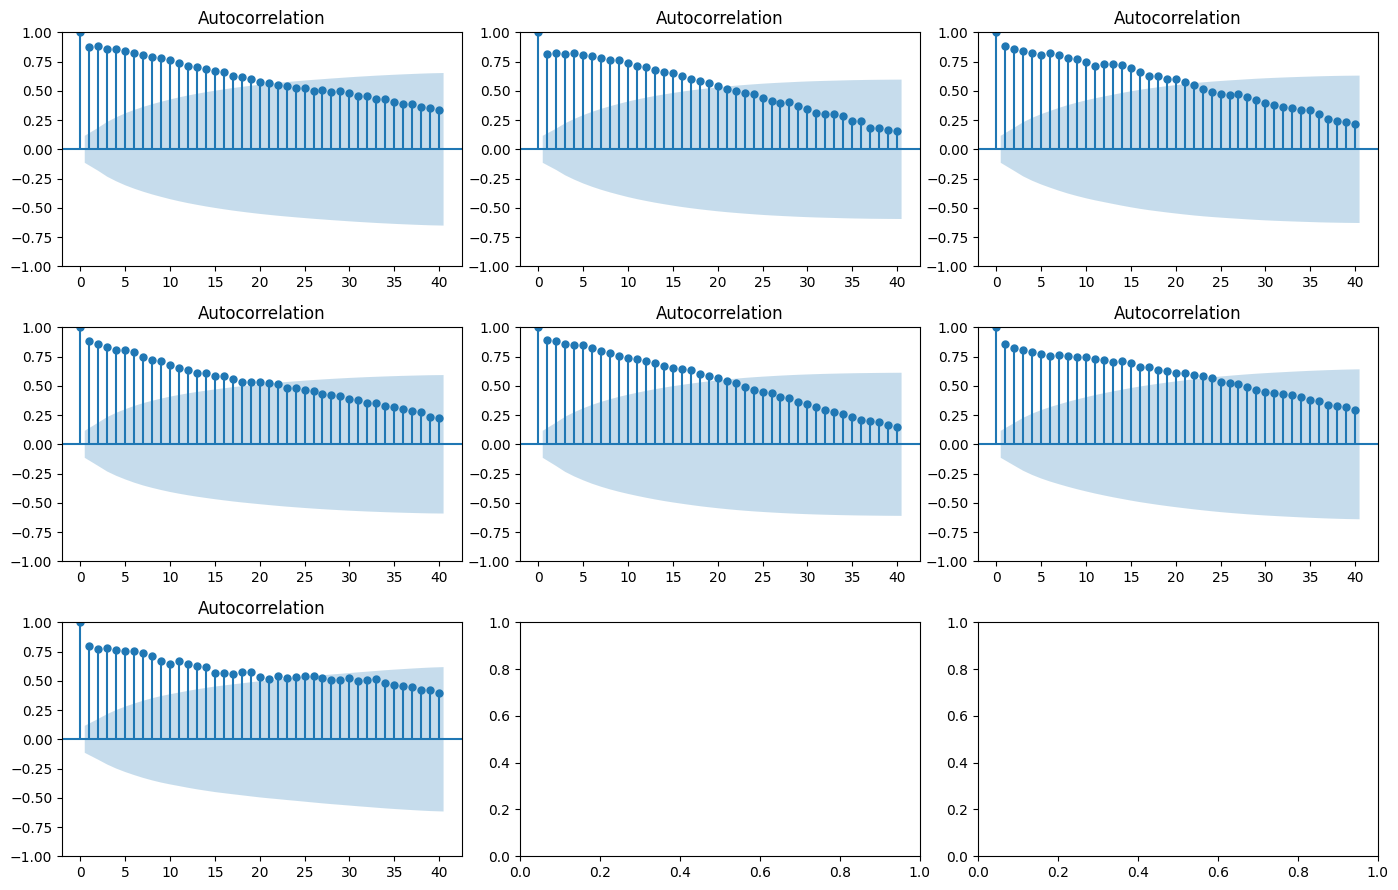

In [129]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Configurar el tamaño de la figura y la disposición de los subgráficos
num_filas = len(series_a_visualizar) // 3 + (len(series_a_visualizar) % 3 > 0)
fig, axs = plt.subplots(num_filas, 3, figsize=(14, 3 * num_filas), squeeze=False)

# Iterar sobre las series y graficar la ACF para cada una
for i, serie in enumerate(series_a_visualizar):
    fila = i // 3
    columna = i % 3

    # Ajustar el índice para obtener el día de la semana correspondiente
    dia_semana = dias_semana[i]

    axs[fila, columna].set_title(f"Serie {serie} - {dia_semana}")
    plot_acf(train_x[serie][0], ax=axs[fila, columna], lags=40)  # Ajusta el número de lags
# Ajustar el diseño de los subgráficos
plt.tight_layout()
plt.show()


Predicciones

El procedimiento de predicciones se repetira para cada uno de los dias (pendiente automatizacion del proceso)

Separe en un par de conjuntos de entrenamiento y prueba

#Domingo

In [130]:
domingo = pd.DataFrame(train_x[3][0])
lunes = pd.DataFrame(train_x[13][0])
martes = pd.DataFrame(train_x[30][0])
miercoles = pd.DataFrame(train_x[33][0])
jueves = pd.DataFrame(train_x[44][0])
viernes = pd.DataFrame(train_x[55][0])
sabado = pd.DataFrame(train_x[77][0])


In [131]:
dia1 = pd.DataFrame(train_x[3][0])
dia1 = dia1.rename(columns={0: 'domingo'})
print(dia1.head())

   domingo
0     16.0
1     15.0
2     13.0
3     14.0
4      8.0


In [132]:
# Dividir en conjuntos de entrenamiento y prueba
train_dia1 = dia1.iloc[:260]  # Número de datos para el conjunto de entrenamiento
test_dia1 = dia1.iloc[260:]  # El resto se usará para el conjunto de prueba
len(test_dia1)


28

In [133]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_dia1['domingo'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.06,
                                                                                                                 smoothing_slope=0.1,
                                                                                                                 smoothing_seasonal=0.5)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')


<ipython-input-133-df8d324c3192>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_dia1['domingo'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.06,


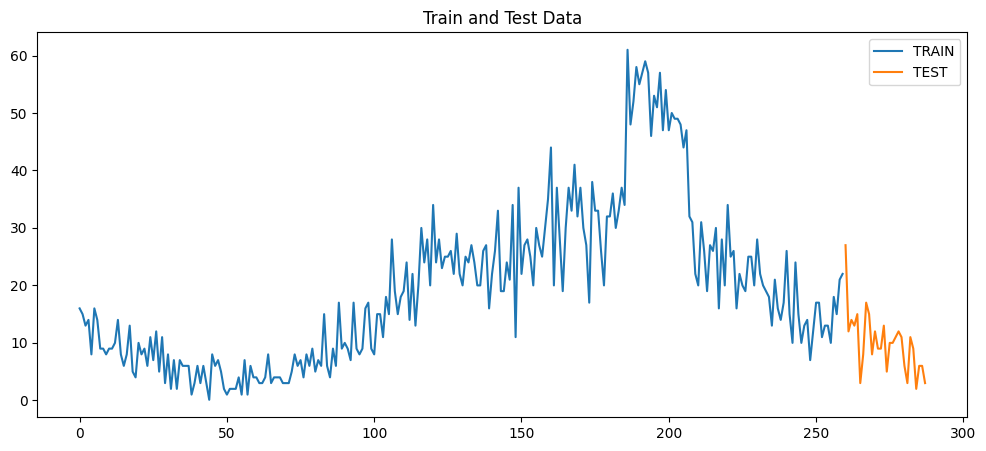

In [134]:
# Visualizar los datos de entrenamiento y prueba
train_dia1['domingo'].plot(legend=True, label='TRAIN')
test_dia1['domingo'].plot(legend=True, label='TEST', figsize=(12, 5))
plt.title('Train and Test Data')
plt.show()


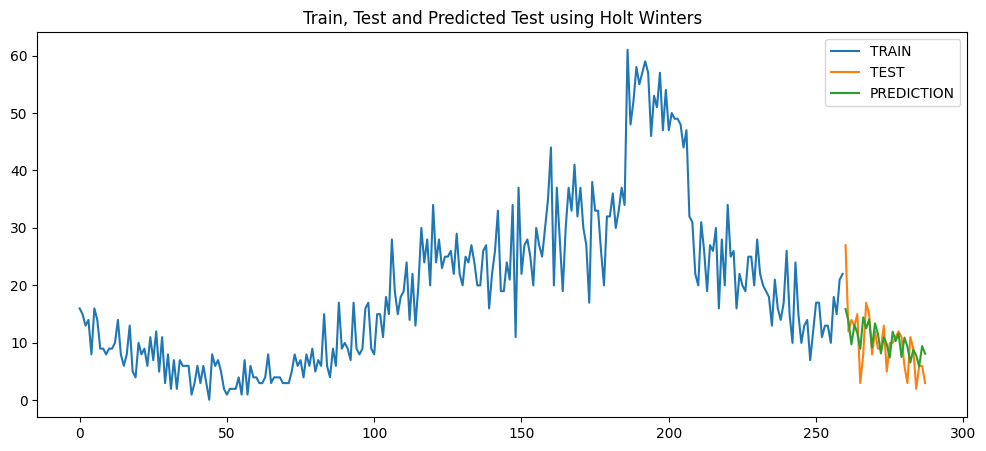

In [135]:
# Visualizar los datos de entrenamiento, prueba y las predicciones
train_dia1['domingo'].plot(legend=True, label='TRAIN')
test_dia1['domingo'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_dia1['domingo'], test_predictions)
mse = mean_squared_error(test_dia1['domingo'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_dia1['domingo'].describe())



resultados_domingo = pd.DataFrame({
    'Día': ['domingo'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 3.2322611943111093
Mean Squared Error = 16.76532811185006
Root Mean Squared Error = 4.094548584624447
count    28.000000
mean     10.000000
std       5.206833
min       2.000000
25%       6.000000
50%      10.000000
75%      12.250000
max      27.000000
Name: domingo, dtype: float64


#Lunes

In [137]:
lunes = pd.DataFrame(train_x[13][0])

lunes = lunes.rename(columns={0: 'lunes'})
print(lunes.head())

   lunes
0    7.0
1    4.0
2    3.0
3    5.0
4    4.0


In [138]:
# Dividir en conjuntos de entrenamiento y prueba
train_lunes = lunes.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_lunes = lunes.iloc[260:]  # El resto se usará para el conjunto de prueba
len(test_lunes)


28

In [139]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_lunes['lunes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.06,
                                                                                                                 smoothing_slope=0.1,
                                                                                                                 smoothing_seasonal=0.5)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')


<ipython-input-139-959681a315f5>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_lunes['lunes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.06,


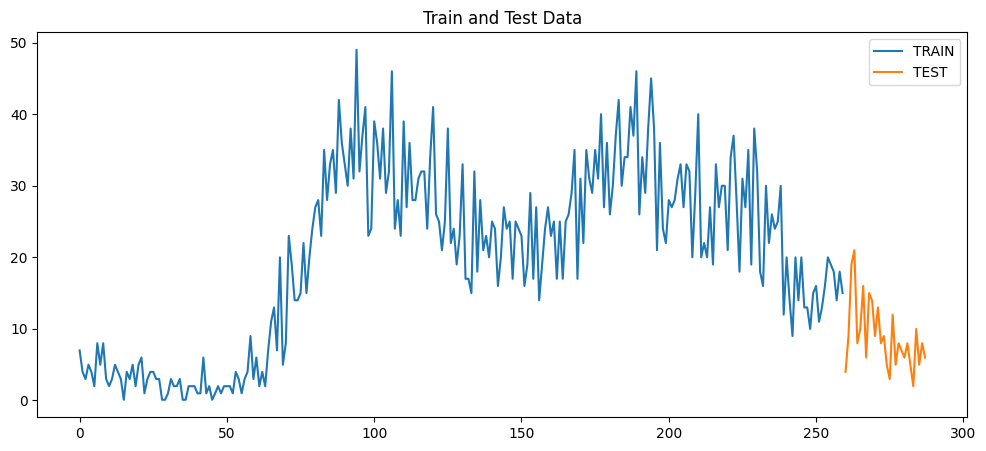

In [140]:
# Visualizar los datos de entrenamiento y prueba
train_lunes['lunes'].plot(legend=True, label='TRAIN')
test_lunes['lunes'].plot(legend=True, label='TEST', figsize=(12, 5))
plt.title('Train and Test Data')
plt.show()


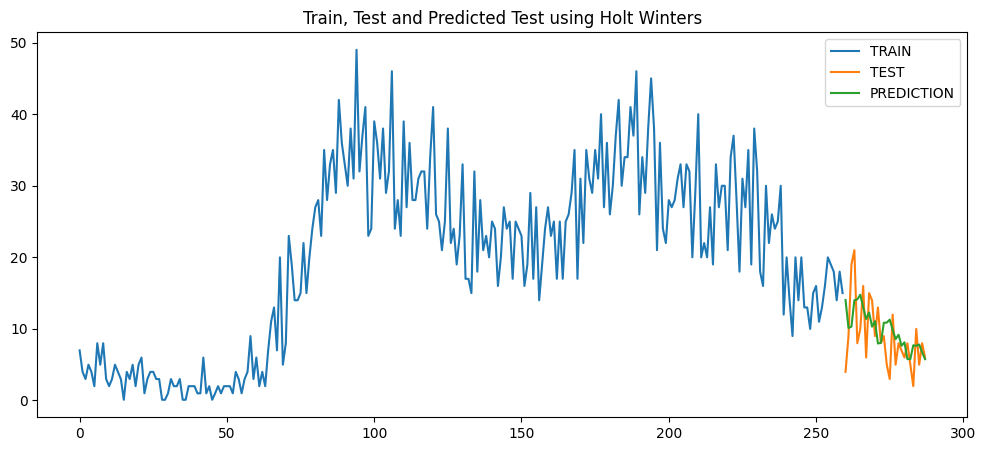

In [141]:
# Visualizar los datos de entrenamiento, prueba y las predicciones
train_lunes['lunes'].plot(legend=True, label='TRAIN')
test_lunes['lunes'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_lunes['lunes'], test_predictions)
mse = mean_squared_error(test_lunes['lunes'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_lunes['lunes'].describe())


resultados_lunes = pd.DataFrame({
    'Día': ['lunes'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 3.599590033293972
Mean Squared Error = 19.9689699984575
Root Mean Squared Error = 4.468665348675989
count    28.000000
mean      8.964286
std       4.678415
min       2.000000
25%       5.750000
50%       8.000000
75%      10.500000
max      21.000000
Name: lunes, dtype: float64


#Martes

In [143]:
martes = pd.DataFrame(train_x[30][0])

martes = martes.rename(columns={0: 'martes'})
print(martes.head())

   martes
0     6.0
1     5.0
2     8.0
3     5.0
4     4.0


In [144]:
# Dividir en conjuntos de entrenamiento y prueba
train_martes = martes.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_martes = martes.iloc[260:]  # El resto se usará para el conjunto de prueba



<ipython-input-145-e8553930ce10>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_martes['martes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.3,


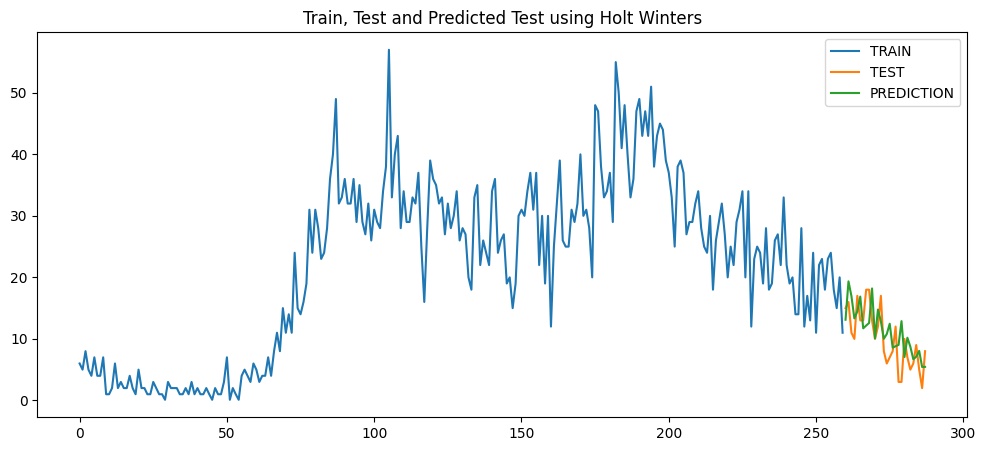

In [145]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_martes['martes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.3,
                                                                                                                 smoothing_slope=0.1,
                                                                                                                 smoothing_seasonal=0.5)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')




# Visualizar los datos de entrenamiento, prueba y las predicciones
train_martes['martes'].plot(legend=True, label='TRAIN')
test_martes['martes'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_martes['martes'], test_predictions)
mse = mean_squared_error(test_martes['martes'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_martes['martes'].describe())


resultados_martes = pd.DataFrame({
    'Día': ['martes'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 3.539277897414544
Mean Squared Error = 16.622976804897952
Root Mean Squared Error = 4.077128499924665
count    28.000000
mean     10.071429
std       4.705620
min       2.000000
25%       6.750000
50%      10.000000
75%      13.000000
max      18.000000
Name: martes, dtype: float64


#Miercoles

In [147]:
miercoles = pd.DataFrame(train_x[33][0])

miercoles = miercoles.rename(columns={0: 'miercoles'})
print(miercoles.head())

   miercoles
0        7.0
1       12.0
2        4.0
3        6.0
4        2.0


In [148]:
# Dividir en conjuntos de entrenamiento y prueba
train_miercoles = miercoles.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_miercoles = miercoles.iloc[260:]  # El resto se usará para el conjunto de prueba



<ipython-input-149-3700cd9355c2>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_miercoles['miercoles'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.05,
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


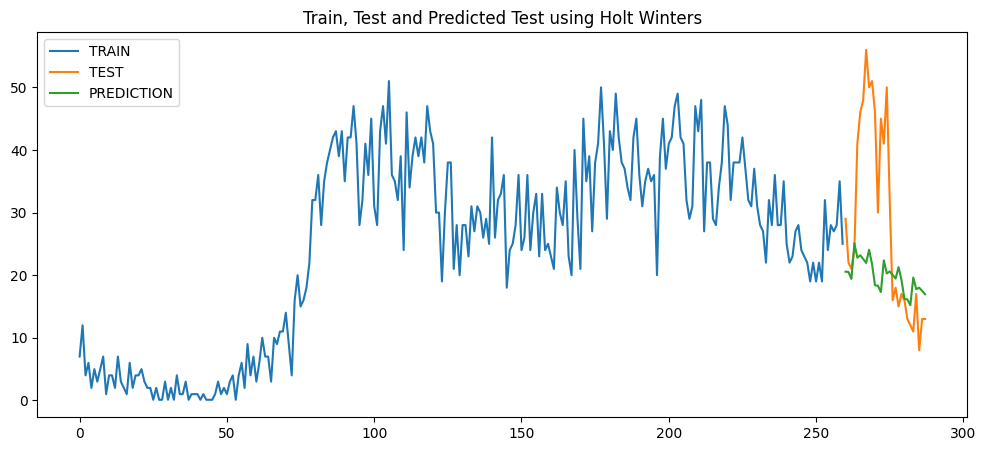

In [149]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_miercoles['miercoles'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.05,
                                                                                                                 smoothing_slope=0.09,
                                                                                                                 smoothing_seasonal=0.4)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')




# Visualizar los datos de entrenamiento, prueba y las predicciones
train_miercoles['miercoles'].plot(legend=True, label='TRAIN')
test_miercoles['miercoles'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_miercoles['miercoles'], test_predictions)
mse = mean_squared_error(test_miercoles['miercoles'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_miercoles['miercoles'].describe())


resultados_miercoles = pd.DataFrame({
    'Día': ['miercoles'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 12.265759550379745
Mean Squared Error = 270.7734349076264
Root Mean Squared Error = 16.455194769665486
count    28.000000
mean     28.607143
std      15.499915
min       8.000000
25%      15.750000
50%      23.000000
75%      45.250000
max      56.000000
Name: miercoles, dtype: float64


#Jueves

In [151]:
jueves = pd.DataFrame(train_x[44][0])

jueves = jueves.rename(columns={0: 'jueves'})
print(jueves.head())

   jueves
0     9.0
1    10.0
2     5.0
3     7.0
4    10.0


In [152]:
# Dividir en conjuntos de entrenamiento y prueba
train_jueves = jueves.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_jueves = jueves.iloc[260:]  # El resto se usará para el conjunto de prueba



<ipython-input-153-546d4f2d2ddf>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_jueves['jueves'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.05,


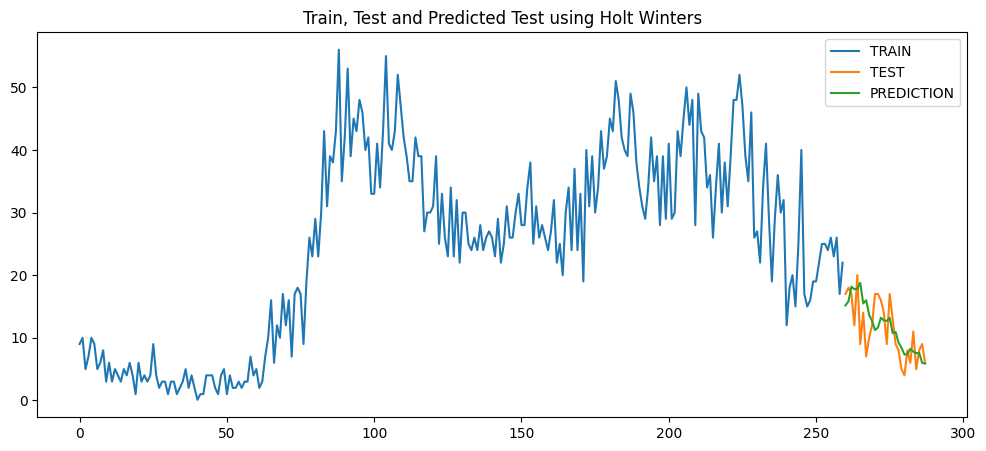

In [153]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_jueves['jueves'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.05,
                                                                                                                 smoothing_slope=0.1,
                                                                                                                 smoothing_seasonal=0.3)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')




# Visualizar los datos de entrenamiento, prueba y las predicciones
train_jueves['jueves'].plot(legend=True, label='TRAIN')
test_jueves['jueves'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [154]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_jueves['jueves'], test_predictions)
mse = mean_squared_error(test_jueves['jueves'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_jueves['jueves'].describe())


resultados_jueves = pd.DataFrame({
    'Día': ['jueves'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 3.0204728773074088
Mean Squared Error = 14.414529896621564
Root Mean Squared Error = 3.7966471914863993
count    28.000000
mean     11.357143
std       4.660427
min       4.000000
25%       8.000000
50%      10.500000
75%      16.250000
max      20.000000
Name: jueves, dtype: float64


#Viernes

In [155]:
viernes = pd.DataFrame(train_x[60][0])

viernes = viernes.rename(columns={0: 'viernes'})
print(viernes.head())

   viernes
0      9.0
1      4.0
2      3.0
3      4.0
4      9.0


In [156]:
# Dividir en conjuntos de entrenamiento y prueba
train_viernes = viernes.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_viernes = viernes.iloc[260:]  # El resto se usará para el conjunto de prueba



<ipython-input-157-4bf66b698246>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_viernes['viernes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.08,


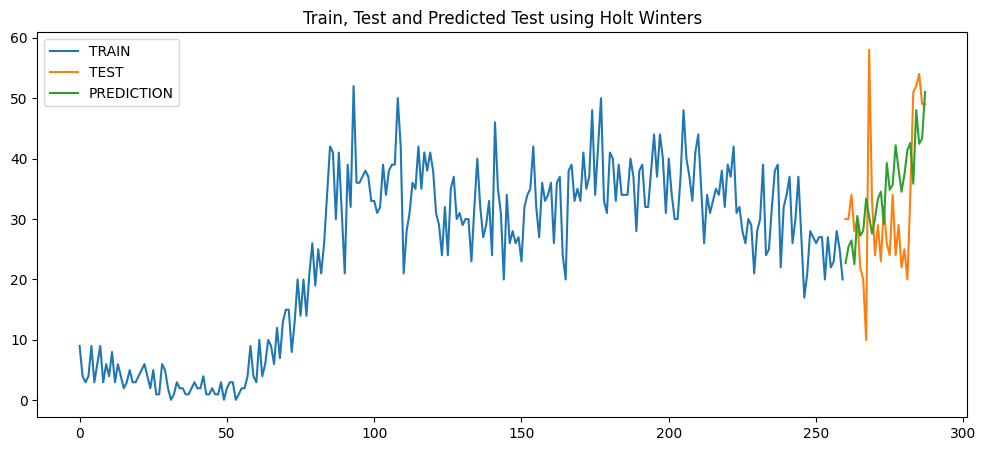

In [157]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_viernes['viernes'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.08,
                                                                                                                 smoothing_slope=0.7,
                                                                                                                 smoothing_seasonal=0.55)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')




# Visualizar los datos de entrenamiento, prueba y las predicciones
train_viernes['viernes'].plot(legend=True, label='TRAIN')
test_viernes['viernes'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_viernes['viernes'], test_predictions)
mse = mean_squared_error(test_viernes['viernes'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_viernes['viernes'].describe())


resultados_viernes = pd.DataFrame({
    'Día': ['viernes'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

Mean Absolute Error = 9.51546157663469
Mean Squared Error = 134.2074385263723
Root Mean Squared Error = 11.584793417509538
count    28.0
mean     32.0
std      12.0
min      10.0
25%      24.0
50%      29.5
75%      34.0
max      58.0
Name: viernes, dtype: float64


#Sabado

In [159]:
sabado = pd.DataFrame(train_x[77][0])

sabado = sabado.rename(columns={0: 'sabado'})
print(sabado.head())

   sabado
0    16.0
1    11.0
2     5.0
3     8.0
4     3.0


In [160]:
# Dividir en conjuntos de entrenamiento y prueba
train_sabado = sabado.iloc[:260]  # Elige el número de datos para el conjunto de entrenamiento
test_sabado = sabado.iloc[260:]  # El resto se usará para el conjunto de prueba



<ipython-input-161-b5758cebbb0f>:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(train_sabado['sabado'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.07,


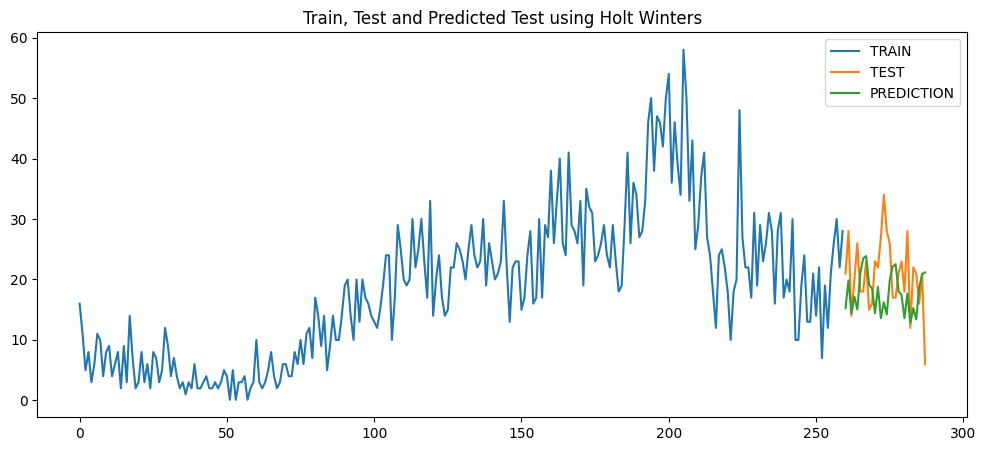

In [161]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo ExponentialSmoothing con tendencia aditiva y estacionalidad multiplicativa
fitted_model = ExponentialSmoothing(train_sabado['sabado'], trend='add', seasonal='mul', seasonal_periods=10).fit(smoothing_level=0.07,
                                                                                                                 smoothing_slope=0.07,
                                                                                                                 smoothing_seasonal=0.5)

# Realizar pronósticos
test_predictions = fitted_model.forecast(28).rename('HW Test Forecast')




# Visualizar los datos de entrenamiento, prueba y las predicciones
train_sabado['sabado'].plot(legend=True, label='TRAIN')
test_sabado['sabado'].plot(legend=True, label='TEST', figsize=(12, 5))
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()


In [162]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular los errores
mae = mean_absolute_error(test_sabado['sabado'], test_predictions)
mse = mean_squared_error(test_sabado['sabado'], test_predictions)
rmse = np.sqrt(mse)

# Imprimir los resultados
print(f'Mean Absolute Error = {mae}')
print(f'Mean Squared Error = {mse}')
print(f'Root Mean Squared Error = {rmse}')

# Descripción de los datos de prueba
print(test_sabado['sabado'].describe())



resultados_sabado = pd.DataFrame({
    'Día': ['sabado'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})



Mean Absolute Error = 6.216590619831601
Mean Squared Error = 59.32791887173962
Root Mean Squared Error = 7.702461870839714
count    28.000000
mean     20.750000
std       5.822212
min       6.000000
25%      17.000000
50%      21.000000
75%      23.750000
max      34.000000
Name: sabado, dtype: float64


Comparativo de errores

In [163]:
# Crear una lista con los DataFrames
dataframes = [resultados_domingo, resultados_lunes, resultados_martes, resultados_miercoles, resultados_jueves, resultados_viernes, resultados_sabado]

# Concatenar los DataFrames en uno solo
resultados_totales = pd.concat(dataframes, ignore_index=True)

# Imprimir los resultados totales
print(resultados_totales)

         Día        MAE         MSE       RMSE
0    domingo   3.232261   16.765328   4.094549
1      lunes   3.599590   19.968970   4.468665
2     martes   3.539278   16.622977   4.077128
3  miercoles  12.265760  270.773435  16.455195
4     jueves   3.020473   14.414530   3.796647
5    viernes   9.515462  134.207439  11.584793
6     sabado   6.216591   59.327919   7.702462


#Observaciones




analisis de
*   graficos (tendencia, estacionalidad, ruido)
*    estacionariedad
*   autocorrelacion
*   Errores





#  PARTE2

Hacer un dataframe que tenga todas las series en un solo dataset con su correspondiente label.

Entonces ahora queremos hacer un modelo de clustering y clasificación (kmeans, PCA, UMAP, random forest, etc....) para determinar si es posible clasificar las series de tiempo en términos de los labels que son justamente los dias, es decir, a ver si podemos predecir el día en términos de algún modelo.

In [164]:
#dataset unificado
df

,Serie,Categoría,Valor
0,1,1,12.0
1,1,1,18.0
2,1,1,11.0
3,1,1,11.0
4,1,1,19.0
...,...,...,...
22459,78,7,22.0
22460,78,7,21.0
22461,78,7,16.0
22462,78,7,21.0


In [165]:
# Estadísticas generales por categoría
estadisticas_categoria = df.groupby('Categoría')['Valor'].describe()

estadisticas_categoria

,count,mean,std,min,25%,50%,75%,max
Categoría,,,,,,,,
1,3456.0,16.344850,10.378727,0.1,8.0,15.0,23.0,61.0
2,2880.0,19.640625,13.109192,0.1,7.0,20.0,30.0,63.0
3,2880.0,21.337813,13.902523,0.1,7.0,24.0,32.0,57.0
4,3168.0,21.583586,13.960399,0.1,8.0,23.0,32.0,56.0
5,3456.0,21.972367,14.123364,0.1,8.0,24.0,33.0,90.0
6,3456.0,23.137789,13.561744,0.1,11.0,25.0,34.0,64.0
7,3168.0,19.139931,11.420015,0.1,9.0,20.0,27.0,61.0


In [166]:
# número de series por categoría
num_series_por_categoria = df.groupby('Categoría')['Serie'].nunique()
print(num_series_por_categoria)

Categoría
1    12
2    10
3    10
4    11
5    12
6    12
7    11
Name: Serie, dtype: int64


In [167]:

# transformar a lo ancho
df_f = (
    df.groupby(['Serie', 'Categoría'])
      .apply(lambda x: x.assign(row_number=x.groupby(['Serie', 'Categoría']).cumcount() + 1))
      .pivot(index=['Serie', 'Categoría'], columns='row_number', values='Valor')
      .reset_index()
)

# Cambiar nombres de las columnas
nuevos_nombres = ["Serie", "Categoría"] + [f"Valor{i}" for i in range(1, 289)]
df_f.columns = nuevos_nombres

# Imprimir el nuevo DataFrame en formato wide
print(df_f)


    Serie Categoría  Valor1  Valor2  Valor3  Valor4  Valor5  Valor6  Valor7  \
0       1         1    12.0    18.0    11.0    11.0    19.0    17.0     4.0   
1       2         1    12.0     9.0    11.0     7.0    12.0    14.0    10.0   
2       3         1     8.0     5.0    10.0    11.0     9.0    10.0     7.0   
3       4         1    16.0    15.0    13.0    14.0     8.0    16.0    14.0   
4       5         1     8.0     6.0     5.0    11.0     7.0     4.0    10.0   
..    ...       ...     ...     ...     ...     ...     ...     ...     ...   
73     74         7    19.0    12.0     8.0     9.0    13.0     3.0     7.0   
74     75         7     9.0    10.0    14.0     8.0    13.0    10.0     6.0   
75     76         7    11.0    10.0     8.0    14.0     8.0     6.0     5.0   
76     77         7     9.0     4.0     3.0     7.0    12.0     6.0     9.0   
77     78         7    16.0    11.0     5.0     8.0     3.0     6.0    11.0   

    Valor8  ...  Valor279  Valor280  Valor281  Valo

<ipython-input-167-90a5244bc26f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.assign(row_number=x.groupby(['Serie', 'Categoría']).cumcount() + 1))


In [168]:
df_f

,Serie,Categoría,Valor1,Valor2,Valor3,Valor4,Valor5,Valor6,Valor7,Valor8,...,Valor279,Valor280,Valor281,Valor282,Valor283,Valor284,Valor285,Valor286,Valor287,Valor288
0,1,1,12.0,18.0,11.0,11.0,19.0,17.0,4.0,6.0,...,10.0,9.0,11.0,8.0,4.0,7.0,3.0,6.0,3.0,6.0
1,2,1,12.0,9.0,11.0,7.0,12.0,14.0,10.0,10.0,...,4.0,7.0,9.0,11.0,6.0,9.0,7.0,10.0,4.0,9.0
2,3,1,8.0,5.0,10.0,11.0,9.0,10.0,7.0,18.0,...,13.0,7.0,6.0,7.0,1.0,2.0,6.0,7.0,8.0,6.0
3,4,1,16.0,15.0,13.0,14.0,8.0,16.0,14.0,9.0,...,12.0,11.0,6.0,3.0,11.0,9.0,2.0,6.0,6.0,3.0
4,5,1,8.0,6.0,5.0,11.0,7.0,4.0,10.0,8.0,...,19.0,13.0,15.0,17.0,10.0,8.0,12.0,16.0,15.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,74,7,19.0,12.0,8.0,9.0,13.0,3.0,7.0,9.0,...,42.0,41.0,39.0,34.0,31.0,27.0,19.0,30.0,21.0,20.0
74,75,7,9.0,10.0,14.0,8.0,13.0,10.0,6.0,6.0,...,16.0,13.0,21.0,18.0,23.0,15.0,33.0,22.0,11.0,16.0
75,76,7,11.0,10.0,8.0,14.0,8.0,6.0,5.0,7.0,...,30.0,21.0,17.0,19.0,18.0,18.0,12.0,14.0,9.0,13.0
76,77,7,9.0,4.0,3.0,7.0,12.0,6.0,9.0,3.0,...,11.0,15.0,15.0,14.0,15.0,9.0,13.0,14.0,9.0,11.0


In [169]:

# Filtrar las series para df_f_test
series_test = [3, 4, 13, 14, 30, 31, 33, 34, 44, 45, 60, 61, 77, 78]
df_f_test = df_f[df_f['Serie'].isin(series_test)]

# df_f_train será el complemento de df_f_test
df_f_train = df_f[~df_f['Serie'].isin(series_test)]

# Verificar las dimensiones de los conjuntos
print("Dimensiones de df_f_train:", df_f_train.shape)
print("Dimensiones de df_f_test:", df_f_test.shape)


Dimensiones de df_f_train: (64, 290)
Dimensiones de df_f_test: (14, 290)


In [170]:
df_f_train

,Serie,Categoría,Valor1,Valor2,Valor3,Valor4,Valor5,Valor6,Valor7,Valor8,...,Valor279,Valor280,Valor281,Valor282,Valor283,Valor284,Valor285,Valor286,Valor287,Valor288
0,1,1,12.0,18.0,11.0,11.0,19.0,17.0,4.0,6.0,...,10.0,9.0,11.0,8.0,4.0,7.0,3.0,6.0,3.0,6.0
1,2,1,12.0,9.0,11.0,7.0,12.0,14.0,10.0,10.0,...,4.0,7.0,9.0,11.0,6.0,9.0,7.0,10.0,4.0,9.0
4,5,1,8.0,6.0,5.0,11.0,7.0,4.0,10.0,8.0,...,19.0,13.0,15.0,17.0,10.0,8.0,12.0,16.0,15.0,13.0
5,6,1,12.0,16.0,17.0,9.0,13.0,7.0,17.0,4.0,...,4.0,8.0,8.0,10.0,17.0,4.0,6.0,3.0,4.0,6.0
6,7,1,13.0,14.0,18.0,11.0,11.0,13.0,13.0,2.0,...,4.0,11.0,9.0,1.0,0.1,0.1,0.1,1.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,7,13.0,7.0,10.0,6.0,12.0,4.0,12.0,9.0,...,14.0,23.0,11.0,9.0,16.0,20.0,13.0,10.0,7.0,16.0
72,73,7,10.0,11.0,5.0,6.0,7.0,9.0,9.0,5.0,...,18.0,19.0,19.0,16.0,16.0,16.0,7.0,16.0,9.0,12.0
73,74,7,19.0,12.0,8.0,9.0,13.0,3.0,7.0,9.0,...,42.0,41.0,39.0,34.0,31.0,27.0,19.0,30.0,21.0,20.0
74,75,7,9.0,10.0,14.0,8.0,13.0,10.0,6.0,6.0,...,16.0,13.0,21.0,18.0,23.0,15.0,33.0,22.0,11.0,16.0


In [171]:
df_f_test

,Serie,Categoría,Valor1,Valor2,Valor3,Valor4,Valor5,Valor6,Valor7,Valor8,...,Valor279,Valor280,Valor281,Valor282,Valor283,Valor284,Valor285,Valor286,Valor287,Valor288
2,3,1,8.0,5.0,10.0,11.0,9.0,10.0,7.0,18.0,...,13.0,7.0,6.0,7.0,1.0,2.0,6.0,7.0,8.0,6.0
3,4,1,16.0,15.0,13.0,14.0,8.0,16.0,14.0,9.0,...,12.0,11.0,6.0,3.0,11.0,9.0,2.0,6.0,6.0,3.0
12,13,2,9.0,5.0,6.0,4.0,4.0,7.0,4.0,5.0,...,7.0,7.0,4.0,10.0,8.0,6.0,2.0,2.0,4.0,9.0
13,14,2,7.0,4.0,3.0,5.0,4.0,2.0,8.0,5.0,...,8.0,7.0,6.0,8.0,5.0,2.0,10.0,5.0,8.0,6.0
29,30,3,4.0,5.0,1.0,4.0,9.0,5.0,3.0,4.0,...,11.0,8.0,10.0,8.0,11.0,3.0,6.0,7.0,4.0,5.0
30,31,3,6.0,5.0,8.0,5.0,4.0,7.0,4.0,4.0,...,3.0,3.0,10.0,7.0,5.0,6.0,9.0,5.0,2.0,8.0
32,33,4,5.0,4.0,6.0,8.0,2.0,4.0,6.0,2.0,...,10.0,13.0,17.0,11.0,11.0,11.0,12.0,8.0,3.0,6.0
33,34,4,7.0,12.0,4.0,6.0,2.0,5.0,3.0,5.0,...,15.0,17.0,16.0,13.0,12.0,11.0,17.0,8.0,13.0,13.0
43,44,5,7.0,3.0,6.0,11.0,8.0,6.0,6.0,10.0,...,12.0,5.0,9.0,4.0,4.0,6.0,9.0,5.0,16.0,8.0
44,45,5,9.0,10.0,5.0,7.0,10.0,9.0,5.0,6.0,...,8.0,5.0,4.0,8.0,6.0,11.0,5.0,8.0,9.0,6.0


Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.25      0.50      0.33         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2

    accuracy                           0.71        14
   macro avg       0.70      0.71      0.69        14
weighted avg       0.70      0.71      0.69        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


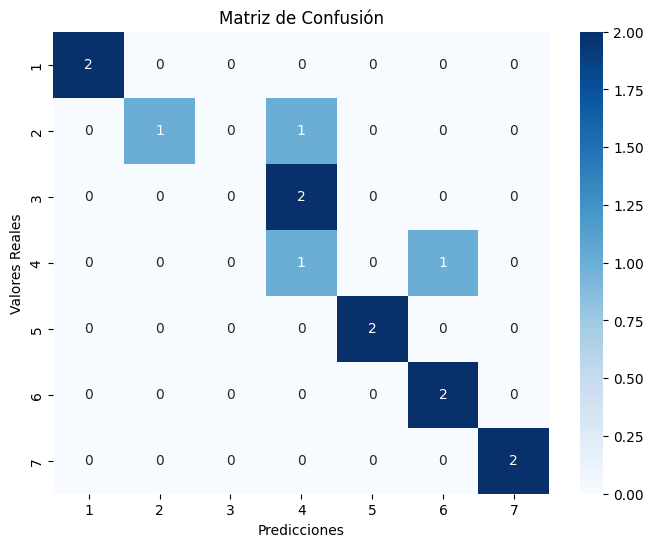

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las características (X) y las etiquetas (y) usando df_f_train
X_train = df_f_train.drop(['Serie', 'Categoría'], axis=1)
y_train = df_f_train['Categoría']

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Inicializar el clasificador RandomForest
rf_classifier = RandomForestClassifier(random_state=100)

# Inicializar GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con la cuadrícula de búsqueda
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo con los mejores hiperparámetros
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Definir las características (X) y las etiquetas (y) usando df_f_test
X_test = df_f_test.drop(['Serie', 'Categoría'], axis=1)
y_test = df_f_test['Categoría']

# Predicciones en el conjunto de prueba
y_test_pred = best_rf_classifier.predict(X_test)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Evaluación del modelo con matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()


KNN

In [173]:
from sklearn.preprocessing import StandardScaler

# Seleccionar las características y las etiquetas
X = df_f.drop(['Serie', 'Categoría'], axis=1)
y = df_f['Categoría']

# Inicializar el escalador
scaler = StandardScaler()

# Normalizar las características
X_normalized = scaler.fit_transform(X)


In [174]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


Accuracy: 0.6875
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.50      0.50      0.50         2
           3       0.33      0.50      0.40         2
           4       1.00      1.00      1.00         2
           5       0.33      0.33      0.33         3
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2

    accuracy                           0.69        16
   macro avg       0.74      0.69      0.70        16
weighted avg       0.73      0.69      0.70        16



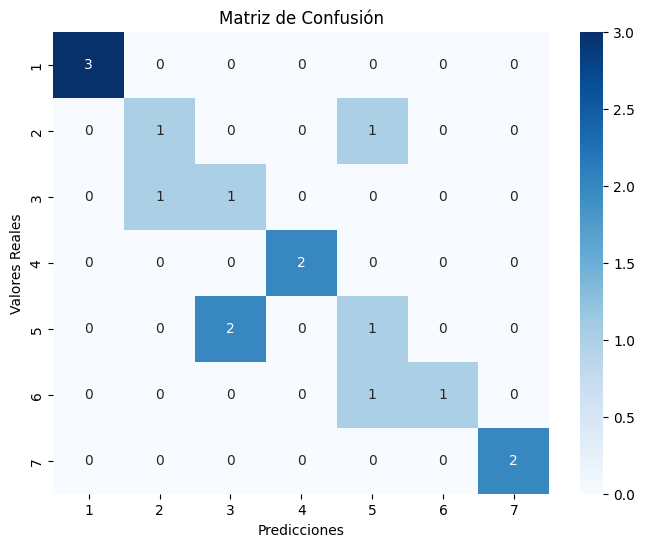

In [175]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar el clasificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=12)  # Puedes ajustar el número de vecinos según tu preferencia

# Ajustar el modelo con el conjunto de entrenamiento
knn_classifier.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = knn_classifier.predict(X_test)

# Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión estilizada con seaborn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()
